<div align='center'>
<img src="../images/c10/DDPG.svg" alt="DDPG" width="400">
</div>

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import gymnasium as gym
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pygame.pkgdata")

class cfg():
    """配置类，存储所有超参数"""
    max_episodes = 200          # 最大训练episode数
    max_steps = 200            # 每个episode的最大步数
    batch_size = 64            # 批量大小
    actor_lr = 0.001           # Actor学习率
    critic_lr = 0.002          # Critic学习率
    gamma = 0.99               # 折扣因子
    tau = 0.005                # 软更新参数 ρ
    memory_size = 50000        # 经验回放缓冲区大小
    hidden_dim = 256           # 隐藏层维度
    noise_std = 0.2            # 噪声标准差
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建Pendulum环境
env = gym.make('Pendulum-v1') 
n_states = env.observation_space.shape[0]  # 状态维度：3
n_actions = env.action_space.shape[0]      # 动作维度：1
action_bounds = [env.action_space.low[0], env.action_space.high[0]]  # 动作范围

print("状态维度:", n_states)
print("动作维度:", n_actions)  
print("动作范围:", action_bounds)
print("状态空间:", env.observation_space)
print("动作空间:", env.action_space)

状态维度: 3
动作维度: 1
动作范围: [np.float32(-2.0), np.float32(2.0)]
状态空间: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
动作空间: Box(-2.0, 2.0, (1,), float32)


In [7]:
class Actor(nn.Module):
    """Actor网络 - 确定性策略μ_θ(s)"""
    def __init__(self, state_dim, action_dim, hidden_dim=256, action_bounds=[-2, 2]):
        super(Actor, self).__init__()
        self.action_bounds = action_bounds
        
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        
        # 权重初始化
        self._initialize_weights()
        
    def _initialize_weights(self):
        """初始化网络权重"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        # 最后一层使用小的权重
        nn.init.uniform_(self.fc3.weight, -3e-3, 3e-3)
        nn.init.uniform_(self.fc3.bias, -3e-3, 3e-3)
        
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))  # tanh输出(-1, 1)
        
        # 缩放到实际动作范围
        action_range = self.action_bounds[1] - self.action_bounds[0]
        action_center = (self.action_bounds[1] + self.action_bounds[0]) / 2
        
        return x * (action_range / 2) + action_center

class Critic(nn.Module):
    """Critic网络 - Q函数Q_φ(s,a)"""
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        
        # 状态编码层
        self.state_fc = nn.Linear(state_dim, hidden_dim)
        
        # 状态-动作融合层
        self.fused_fc = nn.Linear(hidden_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        """初始化网络权重"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        # 最后一层使用小的权重
        nn.init.uniform_(self.fc3.weight, -3e-3, 3e-3)
        nn.init.uniform_(self.fc3.bias, -3e-3, 3e-3)
        
    def forward(self, state, action):
        # 状态编码
        s = torch.relu(self.state_fc(state))
        
        # 状态-动作融合
        x = torch.cat([s, action], dim=1)
        x = torch.relu(self.fused_fc(x))
        x = torch.relu(self.fc2(x))
        q_value = self.fc3(x)
        
        return q_value

class ReplayBuffer:
    """经验回放缓冲区"""
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """存储一个transition"""
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """随机采样batch_size个transition"""
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (np.array(state), np.array(action), np.array(reward), 
                np.array(next_state), np.array(done))
    
    def __len__(self):
        return len(self.buffer)

class OUNoise:
    """Ornstein-Uhlenbeck噪声过程"""
    def __init__(self, action_dim, mu=0, theta=0.15, sigma=0.2):
        self.action_dim = action_dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dim) * self.mu
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(self.action_dim)
        self.state += dx
        return self.state

In [8]:
class DDPGAgent:
    """DDPG智能体"""
    def __init__(self, state_dim, action_dim, action_bounds, cfg):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bounds = action_bounds
        self.device = cfg.device
        
        # 主网络
        self.actor = Actor(state_dim, action_dim, cfg.hidden_dim, action_bounds).to(self.device)
        self.critic = Critic(state_dim, action_dim, cfg.hidden_dim).to(self.device)
        
        # 目标网络
        self.target_actor = Actor(state_dim, action_dim, cfg.hidden_dim, action_bounds).to(self.device)
        self.target_critic = Critic(state_dim, action_dim, cfg.hidden_dim).to(self.device)
        
        # 初始化目标网络参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())
        
        # 优化器
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=cfg.actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=cfg.critic_lr)
        
        # 经验回放
        self.memory = ReplayBuffer(cfg.memory_size)
        
        # 噪声
        self.noise = OUNoise(action_dim, sigma=cfg.noise_std)
        
        # 其他参数
        self.batch_size = cfg.batch_size
        self.gamma = cfg.gamma
        self.tau = cfg.tau
        
    def select_action(self, state, add_noise=True):
        """选择动作"""
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            action = self.actor(state).cpu().numpy().flatten()
            
            if add_noise:
                # 添加OU噪声进行探索
                noise = self.noise.sample()
                action = action + noise
                
                # 将动作限制在有效范围内
                action = np.clip(action, self.action_bounds[0], self.action_bounds[1])
                
        return action
    
    def update(self):
        """更新网络"""
        if len(self.memory) < self.batch_size:
            return None, None
        
        # 从经验回放中采样
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # 转换为tensor
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.BoolTensor(dones).to(self.device)
        
        # 更新Critic网络
        with torch.no_grad():
            # 计算目标Q值: y = r + γ(1-d)Q_tar(s', μ_tar(s'))
            next_actions = self.target_actor(next_states)
            target_q_values = self.target_critic(next_states, next_actions)
            target_q_values = rewards.unsqueeze(1) + (self.gamma * target_q_values * ~dones.unsqueeze(1))
        
        # 当前Q值
        current_q_values = self.critic(states, actions)
        
        # Critic损失
        critic_loss = nn.MSELoss()(current_q_values, target_q_values)
        
        # 更新Critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)
        self.critic_optimizer.step()
        
        # 更新Actor网络
        # Actor损失: -Q(s, μ(s))的均值
        predicted_actions = self.actor(states)
        actor_loss = -self.critic(states, predicted_actions).mean()
        
        # 更新Actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)
        self.actor_optimizer.step()
        
        # 软更新目标网络
        self._soft_update()
        
        return critic_loss.item(), actor_loss.item()
    
    def _soft_update(self):
        """软更新目标网络: θ_tar = τθ + (1-τ)θ_tar"""
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
            
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

In [9]:
# 初始化智能体
cfg = cfg()
agent = DDPGAgent(n_states, n_actions, action_bounds, cfg)

print(f"\n智能体初始化完成!")
print(f"使用设备: {cfg.device}")
print(f"Actor网络: {agent.actor}")
print(f"Critic网络: {agent.critic}")
print(f"经验回放缓冲区容量: {len(agent.memory)}")

# 测试环境
obs, info = env.reset()
print(f"\n初始观测: {obs}")
print(f"观测形状: {obs.shape}")

action = agent.select_action(obs)
print(f"智能体选择的动作: {action}")
print(f"动作形状: {action.shape}")

obs, reward, terminated, truncated, info = env.step(action)
print(f"执行动作后:")
print(f"新观测: {obs}")
print(f"奖励: {reward}")
print(f"是否结束: {terminated or truncated}")


智能体初始化完成!
使用设备: cpu
Actor网络: Actor(
  (fc1): Linear(in_features=3, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)
Critic网络: Critic(
  (state_fc): Linear(in_features=3, out_features=256, bias=True)
  (fused_fc): Linear(in_features=257, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)
经验回放缓冲区容量: 0

初始观测: [ 0.00349569 -0.99999386  0.1244885 ]
观测形状: (3,)
智能体选择的动作: [0.22559111]
动作形状: (1,)
执行动作后:
新观测: [-0.02608475 -0.9996597  -0.59166825]
奖励: -2.458031882164596
是否结束: False


开始训练DDPG智能体...
训练参数: episodes=200, batch_size=64
Actor学习率=0.001, Critic学习率=0.002


训练进度:  10%|█         | 20/200 [00:23<03:37,  1.21s/it]

Episode: 20, 平均奖励: -1112.91, 平均步数: 200.0
  Critic损失: 31.5112, Actor损失: 86.1156


训练进度:  20%|██        | 40/200 [00:47<02:56,  1.10s/it]

Episode: 40, 平均奖励: -211.62, 平均步数: 200.0
  Critic损失: 53.7893, Actor损失: 78.2989


训练进度:  30%|███       | 60/200 [01:10<02:44,  1.18s/it]

Episode: 60, 平均奖励: -147.05, 平均步数: 200.0
  Critic损失: 23.3901, Actor损失: 61.7817


训练进度:  40%|████      | 80/200 [01:33<02:25,  1.21s/it]

Episode: 80, 平均奖励: -175.84, 平均步数: 200.0
  Critic损失: 34.8051, Actor损失: 51.1785


训练进度:  50%|█████     | 100/200 [01:58<02:02,  1.22s/it]

Episode: 100, 平均奖励: -268.50, 平均步数: 200.0
  Critic损失: 17.6176, Actor损失: 42.2513


训练进度:  60%|██████    | 120/200 [02:24<01:45,  1.31s/it]

Episode: 120, 平均奖励: -207.60, 平均步数: 200.0
  Critic损失: 36.9313, Actor损失: 39.5199


训练进度:  70%|███████   | 140/200 [02:46<01:07,  1.12s/it]

Episode: 140, 平均奖励: -172.65, 平均步数: 200.0
  Critic损失: 33.0051, Actor损失: 33.8403


训练进度:  80%|████████  | 160/200 [03:10<00:50,  1.26s/it]

Episode: 160, 平均奖励: -176.57, 平均步数: 200.0
  Critic损失: 28.1378, Actor损失: 30.8736


训练进度:  90%|█████████ | 180/200 [03:34<00:23,  1.16s/it]

Episode: 180, 平均奖励: -151.84, 平均步数: 200.0
  Critic损失: 18.0934, Actor损失: 27.8624


训练进度: 100%|██████████| 200/200 [03:57<00:00,  1.19s/it]

Episode: 200, 平均奖励: -178.81, 平均步数: 200.0
  Critic损失: 19.9446, Actor损失: 25.5847
训练完成!


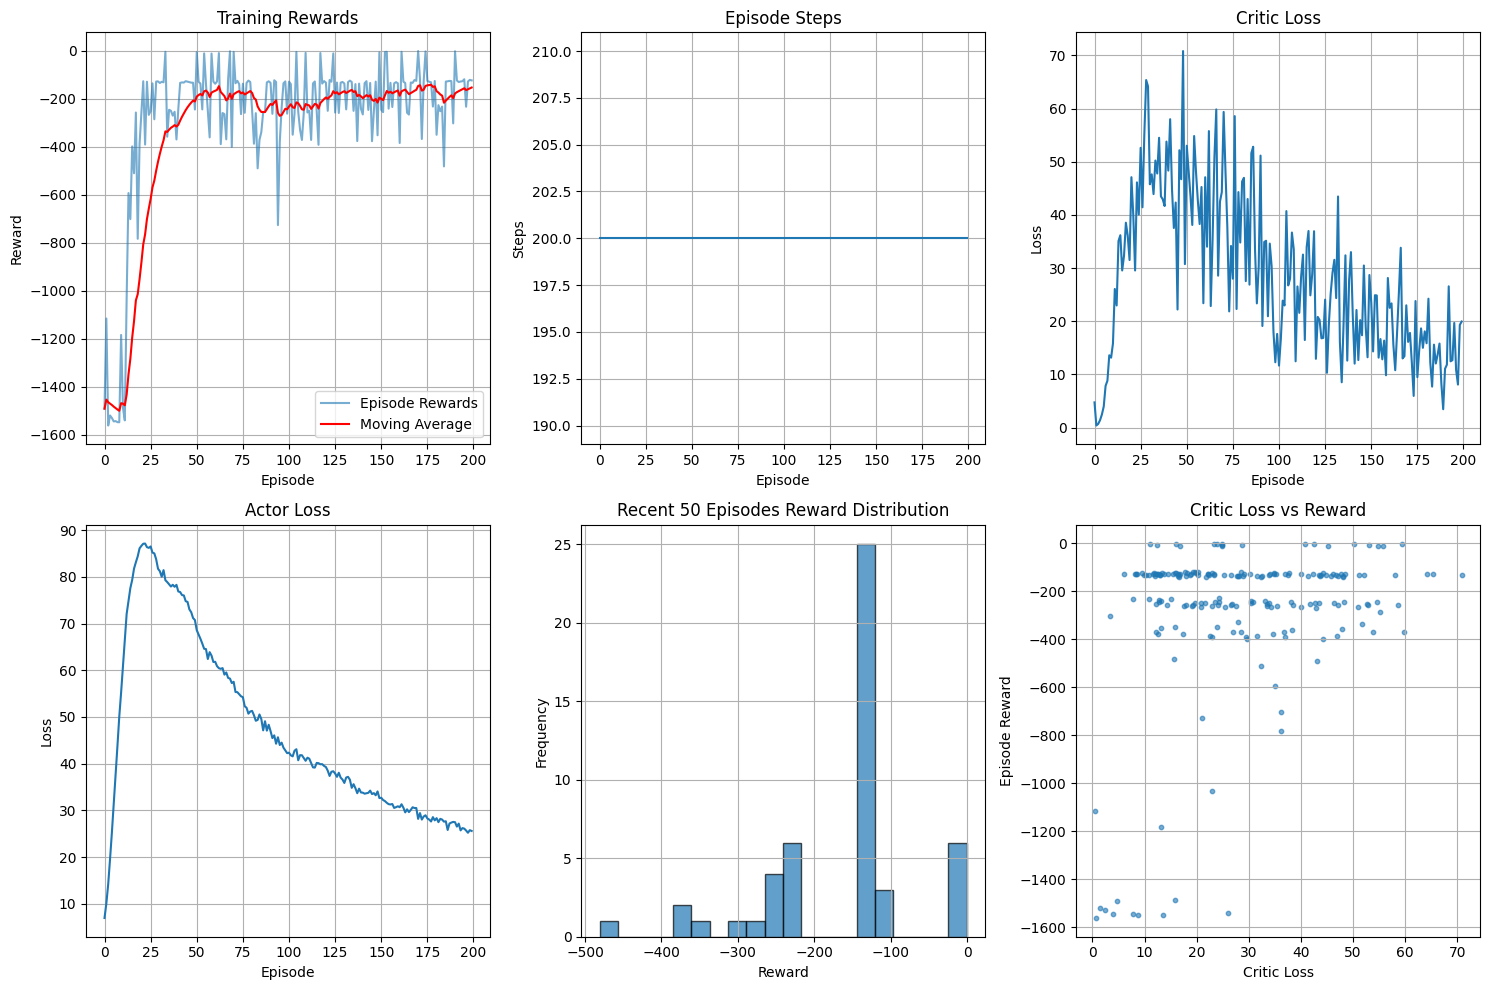


训练统计:
平均奖励: -280.34
最高奖励: -0.57
最低奖励: -1560.43
最后20个episode平均奖励: -178.81
平均episode长度: 200.0


In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 训练DDPG智能体
rewards = []                    # 记录每episode的奖励
moving_average_rewards = []     # 滑动平均奖励
ep_steps = []                   # 每episode的步数
critic_losses = []              # Critic损失
actor_losses = []               # Actor损失

print("开始训练DDPG智能体...")
print(f"训练参数: episodes={cfg.max_episodes}, batch_size={cfg.batch_size}")
print(f"Actor学习率={cfg.actor_lr}, Critic学习率={cfg.critic_lr}")

for i_episode in tqdm(range(1, cfg.max_episodes + 1), desc="训练进度"):
    state, info = env.reset()  # 重置环境状态
    agent.noise.reset()        # 重置噪声
    ep_reward = 0
    ep_critic_loss = 0
    ep_actor_loss = 0
    loss_count = 0
    
    for i_step in range(1, cfg.max_steps + 1):
        # 选择动作 (带噪声探索)
        action = agent.select_action(state, add_noise=True)
        
        # 执行动作
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        ep_reward += reward
        
        # 存储transition到经验回放
        agent.memory.push(state, action, reward, next_state, done)
        
        # 更新状态
        state = next_state
        
        # 更新网络
        critic_loss, actor_loss = agent.update()
        if critic_loss is not None:
            ep_critic_loss += critic_loss
            ep_actor_loss += actor_loss
            loss_count += 1
        
        if done:
            break
    
    # 记录训练信息
    ep_steps.append(i_step)
    rewards.append(ep_reward)
    
    # 记录损失
    if loss_count > 0:
        critic_losses.append(ep_critic_loss / loss_count)
        actor_losses.append(ep_actor_loss / loss_count)
    else:
        critic_losses.append(0)
        actor_losses.append(0)
    
    # 计算滑动平均奖励
    if i_episode == 1:
        moving_average_rewards.append(ep_reward)
    else:
        moving_average_rewards.append(0.9 * moving_average_rewards[-1] + 0.1 * ep_reward)
    
    # 每20个episode打印一次信息
    if i_episode % 20 == 0:
        avg_reward = np.mean(rewards[-20:])
        avg_steps = np.mean(ep_steps[-20:])
        print(f'Episode: {i_episode}, 平均奖励: {avg_reward:.2f}, 平均步数: {avg_steps:.1f}')
        print(f'  Critic损失: {critic_losses[-1]:.4f}, Actor损失: {actor_losses[-1]:.4f}')

print("训练完成!")

# 绘制训练结果
plt.figure(figsize=(15, 10))

# 奖励曲线
plt.subplot(2, 3, 1)
plt.plot(rewards, alpha=0.6, label='Episode Rewards')
plt.plot(moving_average_rewards, 'r-', label='Moving Average')
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)

# 步数曲线
plt.subplot(2, 3, 2)
plt.plot(ep_steps)
plt.title('Episode Steps')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True)

# Critic损失
plt.subplot(2, 3, 3)
plt.plot(critic_losses)
plt.title('Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid(True)

# Actor损失
plt.subplot(2, 3, 4)
plt.plot(actor_losses)
plt.title('Actor Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid(True)

# 最近50个episode的奖励分布
plt.subplot(2, 3, 5)
recent_rewards = rewards[-50:] if len(rewards) >= 50 else rewards
plt.hist(recent_rewards, bins=20, alpha=0.7, edgecolor='black')
plt.title('Recent 50 Episodes Reward Distribution')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.grid(True)

# 奖励和损失的相关性
plt.subplot(2, 3, 6)
if len(rewards) > 10:
    plt.scatter(critic_losses, rewards, alpha=0.6, s=10)
    plt.title('Critic Loss vs Reward')
    plt.xlabel('Critic Loss')
    plt.ylabel('Episode Reward')
    plt.grid(True)

plt.tight_layout()
plt.show()

# 显示训练统计
print(f"\n训练统计:")
print(f"平均奖励: {np.mean(rewards):.2f}")
print(f"最高奖励: {max(rewards):.2f}")
print(f"最低奖励: {min(rewards):.2f}")
print(f"最后20个episode平均奖励: {np.mean(rewards[-20:]):.2f}")
print(f"平均episode长度: {np.mean(ep_steps):.1f}")

开始测试DDPG智能体...
注意：测试时不添加噪声，使用纯确定性策略


测试回合:  20%|██        | 1/5 [00:15<01:00, 15.01s/it]

测试回合 1: 奖励=-125.36, 步数=200


测试回合:  40%|████      | 2/5 [00:28<00:42, 14.08s/it]

测试回合 2: 奖励=-2.46, 步数=200


测试回合:  60%|██████    | 3/5 [00:41<00:27, 13.78s/it]

测试回合 3: 奖励=-336.86, 步数=200


测试回合:  80%|████████  | 4/5 [00:55<00:13, 13.65s/it]

测试回合 4: 奖励=-128.72, 步数=200


测试回合: 100%|██████████| 5/5 [01:07<00:00, 13.55s/it]

测试回合 5: 奖励=-122.31, 步数=200

测试完成!
平均奖励: -143.14
平均步数: 200.00
最高奖励: -2.46
最低奖励: -336.86


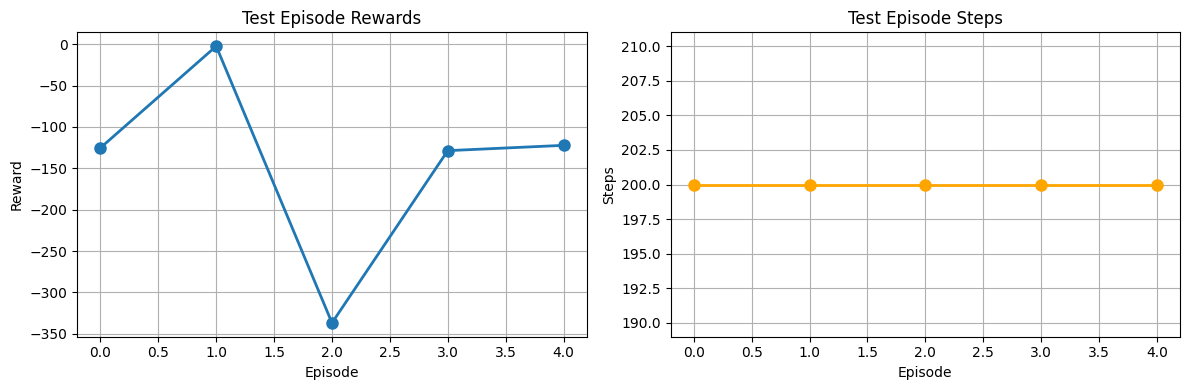


🎯 DDPG vs DDQN 关键区别:
1. ✅ 动作空间: DDPG处理连续动作，DDQN处理离散动作
2. ✅ 策略类型: DDPG使用确定性策略μ_θ(s)，DDQN使用ε-贪心策略
3. ✅ 网络结构: DDPG有Actor-Critic双网络，DDQN只有Q网络
4. ✅ 探索方式: DDPG添加OU噪声，DDQN使用ε-随机探索
5. ✅ 更新方式: DDPG使用软更新τ，DDQN使用硬更新(周期性复制)
6. ✅ 目标计算: DDPG目标是r + γQ_tar(s', μ_tar(s'))，DDQN使用Double Q技巧


In [11]:
# 测试训练好的DDPG智能体
import time

# 创建测试环境（带渲染）
test_env = gym.make('Pendulum-v1', render_mode='human')
test_rewards = []
test_steps = []

print("开始测试DDPG智能体...")
print("注意：测试时不添加噪声，使用纯确定性策略")

for i_episode in tqdm(range(1, 6), desc="测试回合"):  # 测试5个回合
    state, info = test_env.reset()
    ep_reward = 0
    
    for i_step in range(1, cfg.max_steps + 1):
        # 测试时不添加噪声
        action = agent.select_action(state, add_noise=False)
        
        next_state, reward, terminated, truncated, info = test_env.step(action)
        done = terminated or truncated
        
        # 渲染环境
        test_env.render()
        time.sleep(0.02)  # 稍微减慢以便观看
        
        ep_reward += reward
        state = next_state
        
        if done:
            break
    
    # 记录测试信息
    test_steps.append(i_step)
    test_rewards.append(ep_reward)
    print(f"测试回合 {i_episode}: 奖励={ep_reward:.2f}, 步数={i_step}")

test_env.close()

# 显示测试结果统计
print(f"\n测试完成!")
print(f"平均奖励: {np.mean(test_rewards):.2f}")
print(f"平均步数: {np.mean(test_steps):.2f}")
print(f"最高奖励: {max(test_rewards):.2f}")
print(f"最低奖励: {min(test_rewards):.2f}")

# 绘制测试结果
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(test_rewards, 'o-', markersize=8, linewidth=2)
plt.title('Test Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(test_steps, 'o-', markersize=8, linewidth=2, color='orange')
plt.title('Test Episode Steps')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True)

plt.tight_layout()
plt.show()

# 分析DDPG与DDQN的区别
print(f"\n🎯 DDPG vs DDQN 关键区别:")
print("1. ✅ 动作空间: DDPG处理连续动作，DDQN处理离散动作")
print("2. ✅ 策略类型: DDPG使用确定性策略μ_θ(s)，DDQN使用ε-贪心策略")
print("3. ✅ 网络结构: DDPG有Actor-Critic双网络，DDQN只有Q网络")
print("4. ✅ 探索方式: DDPG添加OU噪声，DDQN使用ε-随机探索")
print("5. ✅ 更新方式: DDPG使用软更新τ，DDQN使用硬更新(周期性复制)")
print("6. ✅ 目标计算: DDPG目标是r + γQ_tar(s', μ_tar(s'))，DDQN使用Double Q技巧")

🔍 深入分析DDPG动作选择:

确定性策略输出 (无噪声):
状态1 [1.  0.  0.8] -> 动作: -2.000
状态2 [-1.   0.  -0.8] -> 动作: -2.000
状态3 [0. 1. 0.] -> 动作: -2.000
状态4 [ 0.5 -0.5  0.2] -> 动作: 1.114

随机策略输出 (带OU噪声):
状态1 -> 动作分布: ['-1.523', '-1.658', '-2.000', '-2.000', '-2.000']
状态2 -> 动作分布: ['-1.838', '-2.000', '-2.000', '-2.000', '-2.000']
状态3 -> 动作分布: ['-2.000', '-1.892', '-1.589', '-1.600', '-1.588']
状态4 -> 动作分布: ['1.344', '1.246', '1.247', '1.422', '1.563']

📊 可视化Actor策略:


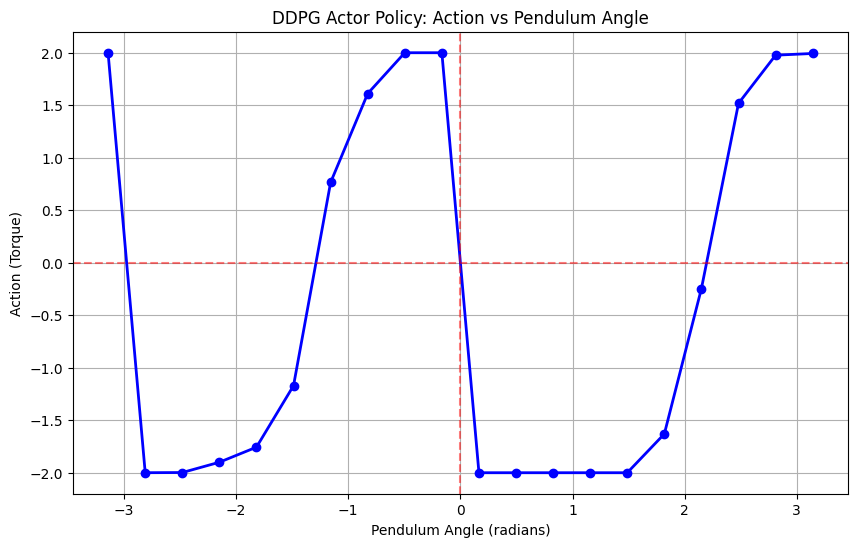

✅ DDPG算法按照第一个单元格设计完成!
✅ 网络结构: Actor(3→256→256→1)
✅ 网络结构: Critic(3+1→256→256→1)
✅ 动作范围: [np.float32(-2.0), np.float32(2.0)]
✅ 软更新参数τ: 0.005
✅ OU噪声标准差: 0.2


In [12]:
# 深入分析动作选择过程
print("🔍 深入分析DDPG动作选择:")

# 创建一些测试状态
test_states = [
    np.array([1.0, 0.0, 0.8]),      # 状态1: 角度向上，低速度
    np.array([-1.0, 0.0, -0.8]),    # 状态2: 角度向下，负速度  
    np.array([0.0, 1.0, 0.0]),      # 状态3: 水平位置，高速度
    np.array([0.5, -0.5, 0.2]),     # 状态4: 混合状态
]

print("\n确定性策略输出 (无噪声):")
for i, state in enumerate(test_states):
    action_clean = agent.select_action(state, add_noise=False)
    print(f"状态{i+1} {state} -> 动作: {action_clean[0]:.3f}")

print("\n随机策略输出 (带OU噪声):")
for i, state in enumerate(test_states):
    actions_noisy = []
    for _ in range(5):  # 采样5次
        action_noisy = agent.select_action(state, add_noise=True)
        actions_noisy.append(action_noisy[0])
    print(f"状态{i+1} -> 动作分布: {[f'{a:.3f}' for a in actions_noisy]}")

# 可视化策略
print("\n📊 可视化Actor策略:")
angles = np.linspace(-np.pi, np.pi, 20)
actions_for_angles = []

for angle in angles:
    # 构造状态: [cos(θ), sin(θ), θ_dot]，假设角速度为0
    state = np.array([np.cos(angle), np.sin(angle), 0.0])
    action = agent.select_action(state, add_noise=False)
    actions_for_angles.append(action[0])

plt.figure(figsize=(10, 6))
plt.plot(angles, actions_for_angles, 'b-', linewidth=2, marker='o')
plt.xlabel('Pendulum Angle (radians)')
plt.ylabel('Action (Torque)')
plt.title('DDPG Actor Policy: Action vs Pendulum Angle')
plt.grid(True)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.show()

print(f"✅ DDPG算法按照第一个单元格设计完成!")
print(f"✅ 网络结构: Actor({n_states}→{cfg.hidden_dim}→{cfg.hidden_dim}→{n_actions})")
print(f"✅ 网络结构: Critic({n_states}+{n_actions}→{cfg.hidden_dim}→{cfg.hidden_dim}→1)")
print(f"✅ 动作范围: {action_bounds}")
print(f"✅ 软更新参数τ: {cfg.tau}")
print(f"✅ OU噪声标准差: {cfg.noise_std}")